<a href="https://colab.research.google.com/github/CAU2022-CAPSTONE-PACETIME/BreathDetector/blob/main/Imu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal
import numpy.linalg as LA

In [2]:
class Imu():
  def __init__(self, df):
    self.data = self.__get_imu_data(df)[0].to_list()
    self.signal = self.__filtering(self.data)
    #self.signal = self.__normalized(self.signal)
    self.signal = self.__cut_data(self.signal)
    self.signal = self.__right_pad(self.signal)
    self.sr = 200
    self.breath = self.__binary_classifier(self.signal)
  
  def __get_imu_data(self, file):
    df = [file[col].dropna() for col in ['accz']]
    return df
  
  def __cut_data(self, signal):
    if len(signal) > 6000:
      signal = signal[:6000]
    return signal
  
  def __right_pad(self, signal):
    if len(signal) < 6000:
      missing_samples = 6000 - len(signal)
      lst = [0 for _ in range(missing_samples)]
      signal = np.append(signal, np.array(lst))
    return signal

  def __filtering(self, signal):
    average = np.mean(signal)
    signal = signal - average
    signal = scipy_signal.savgol_filter(signal, 171, 2)
    #print(signal.shape)
    return signal
  
  def __normalized(self, signal):
    return signal/LA.norm(signal)

  def __gradient(self, signal, start, ws = 0.1):
    sp = start
    hl = int(ws*self.sr)
    sig = signal[sp:sp + hl]
    t = np.arange(sp, sp + hl, 1)
    sl, i = np.polyfit(t, sig, 1)

    return (0 if sl>= 0 else 1)

  def __gradient_list(self, signal, ws = 100):
    res = []
    for i in range(len(signal) - ws):
      res.append(self.__gradient(signal, i))
    return res
  
  def __state_decision_back(self, lst, end, state, ws = 100):
    if end >= ws:
      recent_val = lst[end - ws: end]
    else:
      return True # return False

    return (False if recent_val.count(state) < 30 else True)

  def __state_decision_front(self, lst, start, state):
    if start + 100  < len(lst):
      next = lst[start:start + 100]
    else:
      next = lst[start:]
    
    return (False if next.count(state) > 40 else True)
    

  def __gradient_filtering(self, glst, ws = 300):
    state = 0
    state_conversion = 0
    res = [state]

    for i in range(0, len(glst)):
      if state != glst[i]:
        if self.__state_decision_back(glst, i, state) and i - state_conversion >= 50 and self.__state_decision_front(glst, i, state):
          state = glst[i]
          state_conversion = i
         
      res.append(state)
    return res

  def __inhale_exhale(self, signal, start, ws = 100):
    lst = (signal[start:start+ws] if start + ws <= len(signal) else signal[start:])

    return (1 if lst.count(1) > lst.count(0) else 0)


  def __binary_classifier(self, signal):
    gl = self.__gradient_list(signal)
    self.gradient_signal = self.__gradient_filtering(gl)
    
    res = []
    for i in range(0, 60):
      res.append(self.__inhale_exhale(self.gradient_signal, i * int(self.sr/2)))
    return res

  def get_item(self):
    return self.breath
  

In [3]:
def get_imu_data(data):
  df = [data[col].dropna() for col in ['accx', 'accy', 'accz', 'gyrox', 'gyroy', 'gyroz', 'sound']]
  return df

def plot_signal_total(signal, sr = 200):
  number_sample = signal.shape[0]
  duration = number_sample / sr
  time = np.linspace(0, duration, num=number_sample)

  plt.figure(figsize=(15, 5))
  plt.plot(time, signal)
  plt.axhline(y=0, color='gray', linewidth=3)
  plt.xticks([i for i in range(30)])
  plt.show()

def plot_signal(signal, sr = 200):
  number_sample = signal.shape[0]
  duration = number_sample / sr
  time = np.linspace(0, duration, num=number_sample)

  plt.figure(figsize=(15, 5))
  plt.plot(time, signal)
  plt.axhline(y=0, color='gray', linewidth=3)
  plt.show()

def plot_fft(fft):
  magnitude = np.abs(fft)

  f = np.linspace(0, 200, len(magnitude))

  left_spec = magnitude[:int(len(magnitude)/2)]
  left_f = f[:int(len(magnitude)/2)]


  plt.figure(figsize=(15, 10))
  plt.plot(left_f, left_spec)
  plt.xlabel("Frequency")
  plt.ylabel("Magnitude")
  plt.title("Power spectrum")

def plot_lst(l):
  state = l[0]
  for i, val in enumerate(l):
    if state != val:
      print("~", end = " ")
      print(i*0.5, end = " : ")
      print(state)
      print(i*0.5, end = " ")
      state = val

def plot_path(path_lst, index):
  l = os.listdir(path_lst)
  l.sort()
  for i in l:
    path = path_lst + "/" + i
    print(path)
    df = pd.read_csv(path)

    imu = Imu(df)

    d = imu.get_item()
    plot_signal_total(imu.signal)
    plot_signal_total(np.array(imu.gradient_signal))
    plot_lst(d)

def plot_index(path_lst, index):
  l = os.listdir(path_lst)
  l.sort()
  path = path_lst + "/" + l[index]
  print(l)
  print(path)
  df = pd.read_csv(path)

  imu = Imu(df)

  d = imu.get_item()
  plot_signal_total(imu.signal)

  plot_signal_total(np.array(imu.gradient_signal))
  plot_lst(d)

def plot_direct(path):
  print(path)
  df = pd.read_csv(path)

  imu = Imu(df)

  d = imu.get_item()
  plot_signal_total(imu.signal)

  plot_signal_total(np.array(imu.gradient_signal))
  plot_lst(d) 

def plot_indexlst(path_lst, lst):
  l = os.listdir(path_lst)
  l.sort()
  for index in lst:
    path = path_lst + "/" + l[index]
    print(path)
    df = pd.read_csv(path)

    imu = Imu(df)

    d = imu.get_item()
    plot_signal_total(imu.signal)
    
    plot_signal_total(np.array(imu.gradient_signal))
    plot_lst(d)


57
['Data_2022-10-22_22_19_01.csv', 'Data_2022-11-01_01_07_17.csv', 'Data_2022-11-01_14_46_51.csv', 'Data_2022-11-01_14_47_29.csv', 'Data_2022-11-01_14_48_06.csv', 'Data_2022-11-01_14_48_49.csv', 'Data_2022-11-01_14_49_25.csv', 'Data_2022-11-02_22_53_04.csv', 'Data_2022-11-02_22_53_43.csv', 'Data_2022-11-02_22_54_20.csv', 'Data_2022-11-02_22_54_59.csv', 'Data_2022-11-02_22_55_46.csv', 'Data_2022-11-02_22_59_29.csv', 'Data_2022-11-02_23_00_05.csv', 'Data_2022-11-02_23_00_41.csv', 'Data_2022-11-02_23_01_24.csv', 'Data_2022-11-02_23_02_01.csv', 'Data_2022-11-04_00_04_58.csv', 'Data_2022-11-04_00_05_45.csv', 'Data_2022-11-04_00_06_21.csv', 'Data_2022-11-04_00_07_09.csv', 'Data_2022-11-04_00_11_21.csv', 'Data_2022-11-04_00_12_05.csv', 'Data_2022-11-04_00_12_44.csv', 'Data_2022-11-04_00_13_24.csv', 'Data_2022-11-04_00_14_14.csv', 'Data_2022-11-04_00_15_03.csv', 'Data_2022-11-05_00_17_31.csv', 'Data_2022-11-05_00_18_08.csv', 'Data_2022-11-05_00_18_59.csv', 'Data_2022-11-05_00_19_41.csv', 'Dat

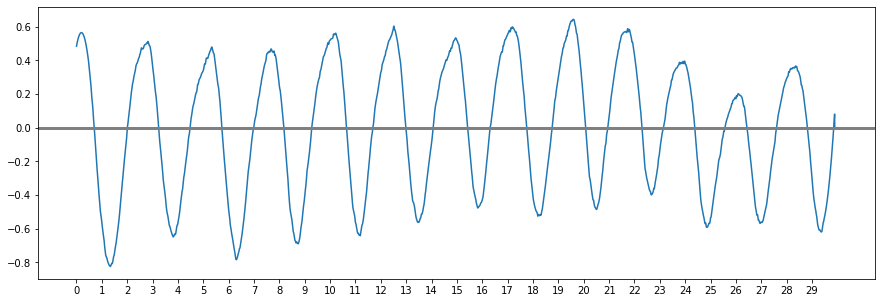

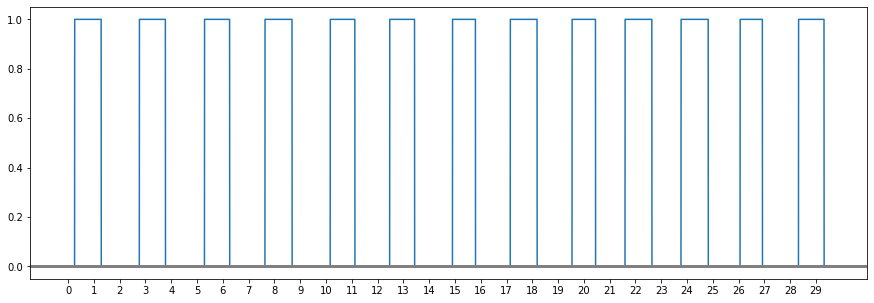

~ 0.5 : 0
0.5 ~ 1.5 : 1
1.5 ~ 3.0 : 0
3.0 ~ 4.0 : 1
4.0 ~ 5.5 : 0
5.5 ~ 6.5 : 1
6.5 ~ 7.5 : 0
7.5 ~ 8.5 : 1
8.5 ~ 10.0 : 0
10.0 ~ 11.0 : 1
11.0 ~ 12.5 : 0
12.5 ~ 13.5 : 1
13.5 ~ 15.0 : 0
15.0 ~ 16.0 : 1
16.0 ~ 17.0 : 0
17.0 ~ 18.0 : 1
18.0 ~ 19.5 : 0
19.5 ~ 20.5 : 1
20.5 ~ 21.5 : 0
21.5 ~ 22.5 : 1
22.5 ~ 24.0 : 0
24.0 ~ 25.0 : 1
25.0 ~ 26.0 : 0
26.0 ~ 27.0 : 1
27.0 ~ 28.5 : 0
28.5 ~ 29.5 : 1
29.5 /content/drive/MyDrive/ColabNotebooks/Data/note9-budslive/Data_2022-12-05_12_45_28.csv


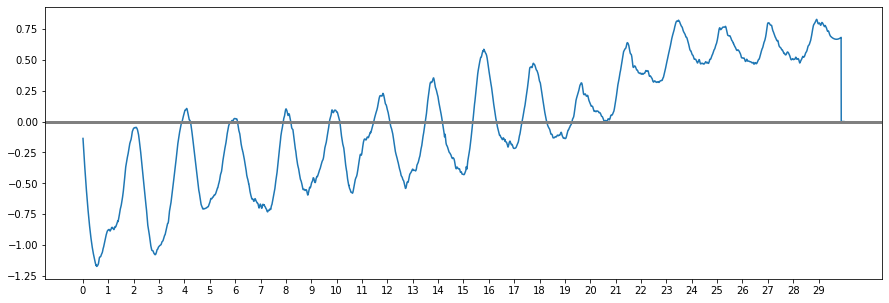

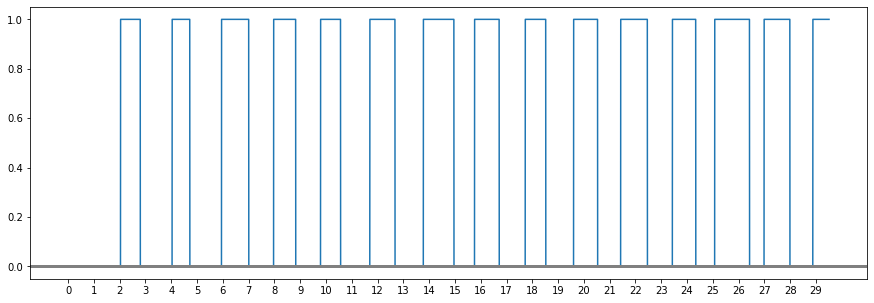

~ 2.0 : 0
2.0 ~ 3.0 : 1
3.0 ~ 4.0 : 0
4.0 ~ 4.5 : 1
4.5 ~ 6.0 : 0
6.0 ~ 7.0 : 1
7.0 ~ 8.0 : 0
8.0 ~ 9.0 : 1
9.0 ~ 10.0 : 0
10.0 ~ 10.5 : 1
10.5 ~ 11.5 : 0
11.5 ~ 12.5 : 1
12.5 ~ 14.0 : 0
14.0 ~ 15.0 : 1
15.0 ~ 16.0 : 0
16.0 ~ 16.5 : 1
16.5 ~ 17.5 : 0
17.5 ~ 18.5 : 1
18.5 ~ 19.5 : 0
19.5 ~ 20.5 : 1
20.5 ~ 21.5 : 0
21.5 ~ 22.5 : 1
22.5 ~ 23.5 : 0
23.5 ~ 24.5 : 1
24.5 ~ 25.0 : 0
25.0 ~ 26.5 : 1
26.5 ~ 27.0 : 0
27.0 ~ 28.0 : 1
28.0 ~ 29.0 : 0
29.0 /content/drive/MyDrive/ColabNotebooks/Data/note9-budslive/Data_2022-12-05_12_46_09.csv


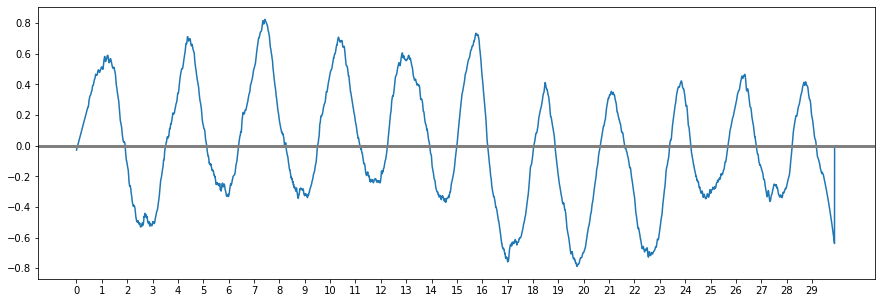

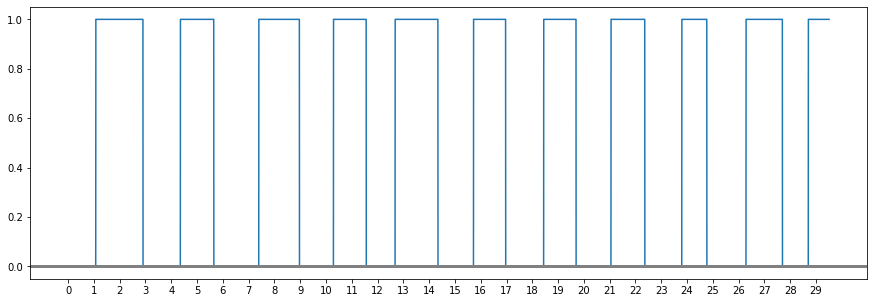

~ 1.0 : 0
1.0 ~ 3.0 : 1
3.0 ~ 4.5 : 0
4.5 ~ 5.5 : 1
5.5 ~ 7.5 : 0
7.5 ~ 9.0 : 1
9.0 ~ 10.5 : 0
10.5 ~ 11.5 : 1
11.5 ~ 12.5 : 0
12.5 ~ 14.5 : 1
14.5 ~ 15.5 : 0
15.5 ~ 17.0 : 1
17.0 ~ 18.5 : 0
18.5 ~ 19.5 : 1
19.5 ~ 21.0 : 0
21.0 ~ 22.5 : 1
22.5 ~ 24.0 : 0
24.0 ~ 25.0 : 1
25.0 ~ 26.5 : 0
26.5 ~ 27.5 : 1
27.5 ~ 28.5 : 0
28.5 

In [16]:
import os

if __name__ == "__main__":
  #path_lst = "/content/drive/MyDrive/ColabNotebooks/Data/note9-airpodspro"
  path_lst = "/content/drive/MyDrive/ColabNotebooks/Data/note9-budslive"
  #path_lst = "/content/drive/MyDrive/ColabNotebooks/Data/zflip-buds2"
  #path_lst = "/content/drive/MyDrive/ColabNotebooks/Data/A21s-airpodspro"
  #path_lst = "/content/drive/MyDrive/ColabNotebooks/Data/A21s-airpodspro-sync"
  #path_lst = "/content/drive/MyDrive/ColabNotebooks/Data/zflip-budspro"
  #path_lst = "/content/drive/MyDrive/ColabNotebooks/Data/note9-budspro"
  #path_lst = "/content/drive/MyDrive/ColabNotebooks/Data/note9-budslive-sync"
  print(len(os.listdir(path_lst)))
  l = os.listdir(path_lst)
  l.sort()
  print(l)


  plot_indexlst(path_lst, [i for i in range(54, 57)])
  #plot_path(path_lst, 5)
  #plot_index(path_lst, 58)
  #plot_direct("/content/drive/MyDrive/ColabNotebooks/Data/Test/Test1.csv")


In [ ]:
def gradient(signal, start, sr = 200, ws = 0.1):
  sp = start
  hl = int(ws*sr)
  sig = signal[sp:sp + hl]
  t = np.arange(sp, sp + hl, 1)

  sl, i = np.polyfit(t, sig, 1)

  if sl >= 0:
    return 0
  else:
    return 1


def gradient_list(signal, sr = 200, ws = 200):
  res = []
  for i in range(len(signal) - ws):
    #print(i, end = "th ")
    res.append(gradient(signal, i))
  return res

val = 1
def dec(lst, end, state, ws = 200):
  global val
  if end >= ws:
    recent_val = lst[end - ws: end]
  else:
    return False
  val = recent_val.count(state)
  if recent_val.count(state) < 100:
    return False
  else:
    return True

def dec2(lst, start, state):
  if start + 100  < len(lst):
    next = lst[start:start + 100]
  else:
    next = lst[start:]
  
  return (False if next.count(state) > 20 else True)



def gradient_filtering(glst, ws = 300):
  state = 0
  state_conversion = 0
  res = [state]

  for i in range(0, len(glst)):
    if state != glst[i]:
      if dec(glst, i, state) and i - state_conversion >= 60 and dec2(glst, i, state):
        state = glst[i]
        state_conversion = i
        print(i, end = "th ")
        print("state changed ", end = " ")
        print(state, end = " ")
        print(val)
    res.append(state)
  return res


# s = gradient_list(axis)
# print("gradient len : ", end = " ")
# print(len(s))

# plot_signal_total(np.array(s))
# filtered = gradient_filtering(s)

# plot_signal_total(np.array(filtered))

# plot_signal_total(axis)
# data_fft = np.fft.fft(axis)
# plot_fft(data_fft)

# 500ms동안 acc z 기울기를 구한다. 음양의 경우 각자의 처리를 해준다. rate에 따라서 보정해준다. 
# ex 기울기가 양일 경우 흡입이라 가정 rate = 30, 즉 1초에 숨 1번이라 가정해보자.
# 양의 기울기로 가고 있다가 음의 기울기를 처음으로 발견 --> Boundary를 할 것인지는 rate에 따른 inhale-exhale 타임으로 보정
# 그 시점을 기점으로 앞 뒤로 기울기를 추가 150ms? 확인 --> 앞 뒤로 양의 기울기가 우세한 경우 노이즈로 판정.

# 결과적으론 500ms단위로 inhale-exhale구분해서 return list 
# inhale : 1 exhale : 0

In [ ]:
# Determine 500ms -> inhale to exhale

def inhale_exhale(signal, start, ws = 100):
  if start + ws <= len(signal):
    lst = signal[start:start+ws]
  else:
    lst = signal[start:]
  
  if lst.count(1) > lst.count(0):
    return 1
  else:
    return 0

def binary_classifier(signal, ws = 500, sr = 200):
  res = []
  for i in range(0, 60):
    res.append(inhale_exhale(signal, i * 100))
  return res
